### Hate and Toxic Comment Detection 

**DataLab USAL - Project 2019/2020** 

### 01. Corpus Exploration

Este primer Notebook servirá como primera toma de contacto. Cargaremos los tweets y daremos el formato adecuado a la información de la que disponemos. Además, realizaremos un análisis exploratorio básico sobre las variables con algunos gráficos descriptivos.


---

#### Librerías

In [ ]:
# standard
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import gzip
import logging
import codecs
global lcode
import warnings
warnings.filterwarnings("ignore")

# nlp
import re
from collections import Counter
from nltk import word_tokenize
import nltk
import spacy
import itertools
import collections
from nltk.corpus import stopwords
import networkx


def initialize_vars():
    import seaborn as sns
    import pandas as pd
    from warnings import filterwarnings
    
    
    # pandas parameters
    pd.set_option('display.max_columns', None)

    # seaborn parameters
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")

%matplotlib inline

data_folder = "../DATA"

initialize_vars()

# Dataset

## Load

In [ ]:
%%time

def load_dataframe(
        get_filename_fn=lambda i: f"file_{i}.csv",
        csv_column_names=[],
        selected_columns=None,
        file_range=(0, 1),
        encoding='utf-8',
        sep='\t'
    ):
    """
    Load the dataframe files in range(`file_range[0]`, `file_range[1]`) 
    using the function `get_filename_fn` to retrieve filenames.
    
    :param get_filename_fn:    Function to retrieve filename based on an index.
    :param file_range:         Tuple (Starting index, End Index).
    :param csv_column_names:   All column names (ordered) present in CSV files.
    :param selected_columns:   Selected columns to read (only these will be present).
    :param encoding:           Encoding for CSV files.
    :param sep:                Column separator
    :returns:                  Full dataframe
    """
    import pandas as pd

    
    # Set dataframes generator
    dataframes = (pd.read_csv(
        filepath_or_buffer=get_filename_fn(i), 
        sep=sep, 
        names=csv_column_names, 
        encoding=encoding,
        usecols=selected_columns if selected_columns is not None else csv_column_names
    ) for i in range(file_range[0], file_range[1]))

    # Load and concat
    return pd.concat(dataframes).astype(str)
    

tweets = load_dataframe(
    get_filename_fn=lambda i: f"{data_folder}/streaming_odio_politicas_{i}.txt",
    file_range=(0, 9),
    csv_column_names=["id", "date", "user", "tweet", "via", "user_id", "followers", "following", 
                      "statuses", "loc", "link", "col12", "col13", "user_bio", "col15", "col16", 
                      "col17", "tweet_type", "col19", "politician_mention", "col21", "politician_rt", 
                      "col23", "col24", "hashtag", "col26","count_creation", "col28", "col29", "col30"],
    selected_columns=["date", "user", "tweet", "via", "followers", "following", "loc", "link", "col12", 
                      "user_bio", "col17", "tweet_type", "politician_mention", "politician_rt", "col24", 
                      "hashtag", "count_creation", "col28"]
)

## Create new column RT, True if it is an RT 

In [175]:
%%time

def create_rt_and_rt_source():
    import numpy as np
    import re

    
    tweets['RT'] = tweets["tweet_type"] == "RT"

    # Create new column RT_source, if RT, with retweeted account
    # Search for "RT @something" in the tweet and selects the `@something` part with `rt_source` group
    regex = re.compile("^RT +?(?P<rt_source>@[a-zA-Z_0-9]+)")
    
    select_rt_source = lambda text: regex.search(text).group('rt_source')

    tweets.loc[tweets['RT'], 'RT_source'] = tweets[tweets['RT']]['tweet'].apply(select_rt_source)

    # If not RT, RT_source = ''
    tweets.loc[np.logical_not(tweets['RT']), 'RT_source'] = ''

    
create_rt_and_rt_source()

# Vars type casting

In [ ]:
tweets["date"] = pd.to_datetime(tweets["date"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
tweets["followers"] = pd.to_numeric(tweets["followers"], errors="coerce")
tweets["following"] = pd.to_numeric(tweets["following"], errors="coerce")

## Dataset cleaning

In [168]:
%%time

def clean_dataset_column(column_array):
    import re
    from unidecode import unidecode
    
    # Individual regexes to match and clean
    remove_regexes = [
        "[\]\[\"?!,. ]+",              # Sequence of whitespace
        "(RT )?@[_A-Za-z0-9]+:?",      # '@' mentions, RT '@' mentions
        "[a-z]+:\/\/[a-zA-Z0-9./_\-]+",# (http|https|any)://url links
    ]

    # Compile regex to speed up processing; join regexes with an 'or' and match any occurrence
    regex = re.compile(f"({'|'.join(remove_regexes)})+")

    # 
    clean_tweet_fn = lambda text: regex.sub(" ", unidecode(text)).strip().lower()

    # clean matched elements and set it to a dataset column
    return column_array.apply(clean_tweet_fn)


tweets['clean_tweet'] = clean_dataset_column(tweets['tweet'])

## Stop words declaration

In [ ]:
%%time

def get_stop_words_set():
    from nltk.corpus import stopwords
    from spacy.lang.es.stop_words import STOP_WORDS as spacy_stop_words
    
    # Download stopwords assets
    nltk.download('stopwords')
    
    stopwords_languages = (
        'spanish',
        'english'
    )
    
    custom_stop_words={
        'q', 'k', 'tiene','vuestra','habiendo','han','tendremos','tenemos','hubisteis','hayas',
        'habian','seas','muy','se','tienes','habidos','mia','tuviste','tengas','contra','tuvieseis',
        'habiais','he','estariamos','estuvieron','para','fui','has','al','era','tenidos','nada',
        'estados','tuvieran','teneis','sentidas','fueran','estare','en','sois','que','estuvieras',
        'tendras','tuvieses','estado','erais','sus','si','seais','estuvieramos','hubimos','tuyas',
        'esteis','quienes','ella','todos','sea','fueses','otra','tenido','mios','del','sean','tenia',
        'mas','tambien','fueseis','ni','vuestro','habiamos','fueras','tu','que','sentida','antes',
        'y','hube','tendrian','tu','estarian','este','tuvierais','os','tendre','no','fueramos','vosotras',
        'ti','tendrias','seran','habriais','esta','estos','lo','estuviesemos','hubieses','eres',
        'nuestra','hayamos','estaras','la','estamos','habria','somos','tendran','yo','habras','habra',
        'seria','hay','poco','tendriamos','por','el','pero','habrias','estuviste','sobre','otro',
        'estaran','habeis','esos','tuvieron','hayais','cuando','estadas','estuvo','tenias','estemos',
        'sintiendo','teniamos','habias','tuvo','hubiese','ha','vuestras','son','esto','nosotros',
        'estaba','como','habre','habreis','mucho','habrian','vosotros','eras','fue','sentid','sera',
        'mi','estas','ante','es','tuvieramos','mias','me','hubieras','tenian','esta','estuvieses',
        'hubiesemos','tuve','fuese','estuvierais','los','hubieron','desde','fuiste','cual','estuve',
        'tus','mis','ya','nuestros','tuviese','donde','su','eran','ese','serias','habidas','durante',
        'habran','tengamos','tuvimos','le','estaban','seamos','estarias','un','algo','tengan','sereis',
        'estabamos','tuviesemos','estara','hubieseis','serian','seriais','tenida','estabais','estuvimos',
        'estuviesen','mio','fueron','siente','ellos','e','suya','estuviese','estuvieran','nosotras',
        'estuvieseis','o','tienen','las','habriamos','estuviera','tengo','estando','muchos','tenidas',
        'tendra','estaremos','el','hubo','estaria','sere','a','vuestros','hubierais','suyo','tuvisteis',
        'otros','tuvieras','eramos','estes','habido','estoy','suyas','estabas','fuerais','algunas',
        'esten','soy','otras','tanto','estariais','estareis','hasta','habremos','esa','hayan','mi',
        'eso','quien','tened','estan','tuya','hubieran','entre','seriamos','unos','hubiera','porque',
        'algunos','estas','fuera','estar','habida','fuesen','tendreis','con','tengais','suyos',
        'este','estad','fuisteis','sentido','todo','hubieramos','estuvisteis','sin','seremos','tuyos',
        'de','uno','les','nuestro','sentidos','teniais','hubiesen','hubiste','tuviesen','esas','tendria',
        'seras','teniendo','estais','te','tuyo','fuimos','haya','fuesemos','habia','nuestras','tenga',
        'una','tendriais','tuviera','hemos','nos','ellas','estada'
    }

    return {unidecode(word) for word in custom_stop_words | spacy_stop_words | set(stopwords.words(stopwords_languages))}


stop_words = get_stop_words_set()

## Simple tokenization

In [300]:
# Requires `stop_words` and `tweets['clean_tweet']`

def simple_tokenization():
    tweets['tokens'] = tweets['clean_tweet'].apply(lambda text: [word for word in text.split() if word not in stop_words])
    
    
simple_tokenization()

# Term frequency - Inverse document frequency

In [ ]:
%% time

def create_tfidf_matrix(column_array):
    import es_core_news_sm
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # Load spacy es_core_news_sm
    # Install with `python -m spacy install es_core_news_sm` in your conda distribution
    nlp = es_core_news_sm.load()
    
    # Discarded part of speech set
    discarded_pos_set = {'PROPN', 'CONJ', 'ADP', 'DET'}
    
    # Test if token_is_valid
    token_is_valid = lambda t: t.is_alpha and not t.is_stop and t.pos_ not in set_pos
    
    # Pick lemma_.lower() for token in text if token_is_valid
    tokenizer = lambda text: (t.lemma_.lower() for t in nlp(text) if token_is_valid(t))
    
    # Define vectorizer parameters
    vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000, min_df=3, stop_words=stop_words,
                                 use_idf=True, tokenizer=tokenizer, ngram_range=(1,3))

     # Fit matrix
    matrix = vectorizer.fit_transform(column_array)
    
    return matrix, vectorizer


tfidf_matrix_train, tfidf_vectorizer = create_tfidf_matrix(tweets['clean_tweet'])

## Save csr_matrix data to a hdf5 file

In [1]:
# Load functions & variables

class CSRMatrixHDF5FileHandler():
    # Initialize class
    def __init__(self, filename = 'csr_matrix.hd5', group='Mcsr'):
        self.filename = filename
        self.group = group
    
    def save(self, matrix):
        """Save a csr_matrix into `self.filename` hdf5 file"""
        import h5py
        with h5py.File(self.filename, 'w') as f:
            g = f.create_group(self.group)
            g.create_dataset('data',data=matrix.data)
            g.create_dataset('indptr',data=matrix.indptr)
            g.create_dataset('indices',data=matrix.indices)
            g.attrs['shape'] = matrix.shape
        
    def load(self):
        """Load a csr_matrix from `self.filename` hdf5 file"""
        import h5py
        from scipy import sparse
        with h5py.File(self.filename,'r') as f:
            g = f[self.group]
            return sparse.csr_matrix((g['data'][:], g['indices'][:], g['indptr'][:]), g.attrs['shape'])
        

# Load handler
matrix_file_handler = CSRMatrixHDF5FileHandler(
    filename = 'tfidf_matrix.hd5'
)

In [2]:
# Save command
# matrix_file_handler.save(tfidf_matrix_train)

# Load command
tfidf_matrix_train = matrix_file_handler.load()

OSError: Unable to open file (unable to open file: name = 'tfidf_matrix.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Graph csr_matrix

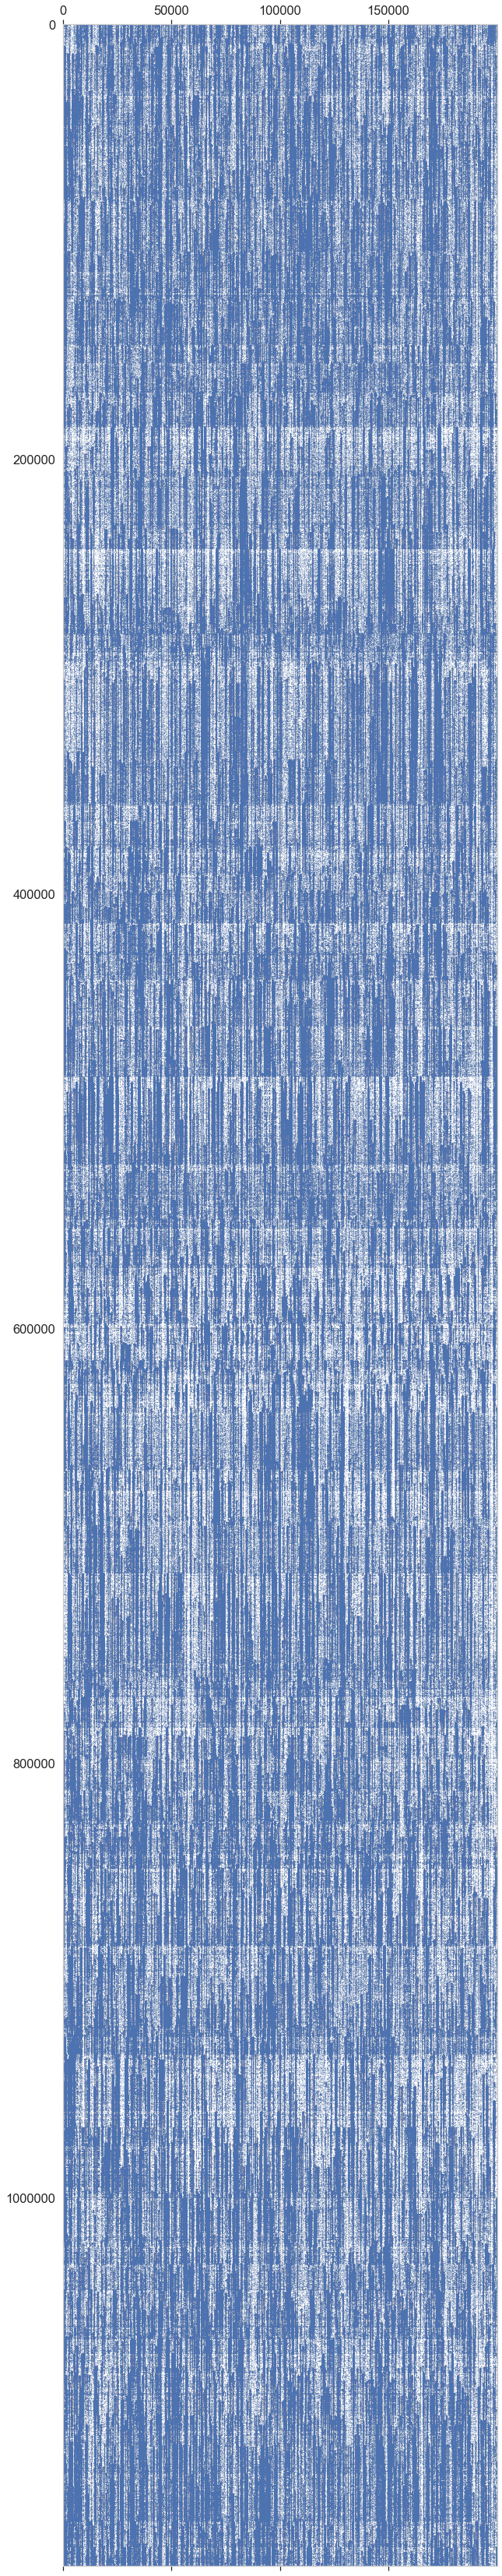

In [128]:
%%time

# Requires `tfidf_matrix_train`

def graph_csr_matrix():
    import matplotlib.pyplot as plt
    
    
    plt.figure(figsize=(10, 80))
    plt.spy(tfidf_matrix_train, markersize=0.05, precision=0.02)
    plt.show()
    
    
graph_csr_matrix()

# Word Frequencies

### Filtrar por tweets dirigidos a politicos (dir) y tweets escritos por politicos (col3)

Filtrar por politico tanto en col3 como en Dir, ver cuantos escribe cada uno y cuantos recibe, ver las palabras más habituales.

Filtrar los que son RT, obtener palabras más frecuentes tanto  RT en general, como por dirigido a politico y escrito por poltico. 

Filtramos los tweets escritos por los distintos politicos y obtenemos el número de tweets escritos y las palabras más frecuentes.

In [349]:
%%time

# Requires the execution of `simple_tokenization`

def create_counts():
    from itertools import chain
    from collections import Counter

    return {
        # Count by user
#         'user': tweets.groupby('user').apply(lambda el: Counter(chain(*el['tokens']))),
        # All words count
        'global': Counter(chain(*tweets['tokens'])),
        # RT with most common hastags
        'rt_hashtag': Counter(tweets[(tweets["tweet_type"] == "RT") & (tweets["hashtag"] != 'None')]["hashtag"])
    }


counts = create_counts()

CPU times: user 2.15 s, sys: 25.1 ms, total: 2.17 s
Wall time: 2.17 s


## Graphs

CPU times: user 114 ms, sys: 4.84 ms, total: 119 ms
Wall time: 120 ms


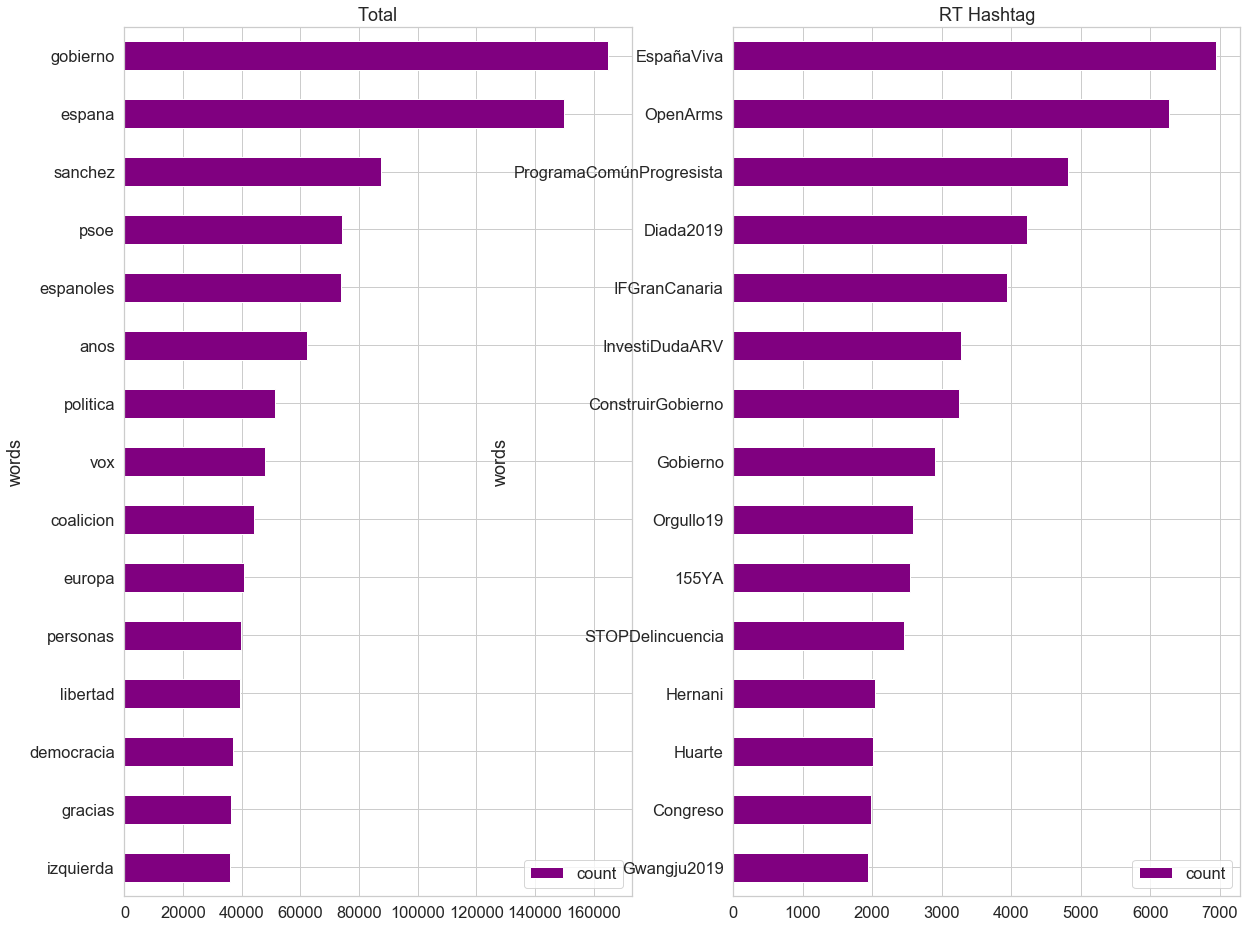

In [350]:
%%time

def graph_word_frequencies():
    import pandas as pd    
    import matplotlib.pyplot as plt
    
    politicians = ["@InesArrimadas", "@Irene_Montero_", "@carmencalvo_", "@cayetanaAT", 
               "@Albert_Rivera", "@Pablo_Iglesias_", "@sanchezcastejon", "@pablocasado_",
               "@Santi_ABASCAL", "@monasterioR"]
    
    # Set this variable with as many graphs as you like
    counts_to_graph=[
        # (graph_title,    Counter)
        ('Total',          counts['global']),
        ('RT Hashtag',     counts['rt_hashtag']),
    ]# + [(user, counts['user'][user]) for user in politicians]
    
    graph_columns = 2
    graph_rows = len(counts_to_graph)//graph_columns
    
    df_counts = [(name, pd.DataFrame(count.most_common(15), columns=['words', 'count']
    )) for name, count in counts_to_graph]
    
    fig, axs = plt.subplots(graph_rows, graph_columns, figsize=(20, 16 * graph_rows))

    
    # Plot horizontal bar graph
    pos_range = [(i, j) for i in range(graph_rows) for j in range(graph_columns)]

    for pos_x, pos_y in pos_range[:len(df_counts)]:       
        title, frame = df_counts[2*pos_x+pos_y]
        ax = axs[pos_x, pos_y] if graph_rows > 1 else axs[pos_y]
        
        ax.set_title(title)
        
        frame.sort_values(by='count').plot.barh(
            x='words',
            y='count',
            ax=ax,
            color="purple"
        )
    
    
graph_word_frequencies()

# Time splits

In [136]:
%%time

def create_all_delta_splits(
        dataset=tweets, 
        c_date=column_names[1], 
        date_range = (date(2019, 7, 5), date(2019, 9, 13))
    ):
    
    from datetime import date, timedelta

    
    # Select observations between two datetimes
    def delta_range(date_range, date_delta):
        """Creates `date_ranges(start, end)` given an original date_range and delta time for each range"""
        from math import ceil

        total_delta = date_range[1] - date_range[0]
        deltas_in_total = total_delta/date_delta
        
        return (
            (date_range[0] + delta_idx * date_delta, date_range[0] + (delta_idx + 1) * date_delta) 
            for delta_idx in range(ceil(deltas_in_total))
        )

    
    def create_delta_split(date_range, date_delta, dataset=dataset, c_date=c_date):
        """Create an split `dataset` array of date_ranges of size `date_delta` in the `dataset`[`c_date`] column"""
        return [tweets[(tweets[c_date] >= str(start)) & (tweets[c_date] < str(end))] for start, end in delta_range(date_range, date_delta)]

    
    monthly_delta_split = create_delta_split(
        date_range,
        timedelta(days=30)
    )

    fortnightly_delta_split = create_delta_split(
        date_range,
        timedelta(days=15)
    )

    weekly_delta_split = create_delta_split(
        date_range,
        timedelta(days=7)
    )

    daily_delta_split = create_delta_split(
        date_range,
        timedelta(days=1)
    )
        
    return monthly_delta_split, fortnightly_delta_split, weekly_delta_split, daily_delta_split


# delta_size: month = 0, fortnight = 1, week = 2, day = 3
# idx_delta: 0 = 1st, 1 = 2nd, 2 = 3rd, 3 = 4th, ...
# Usage: dataset_delta_splits[delta_size][idx_delta]
# Example: dataset_delta_splits[2][1] ==> second week in the date_range
dataset_delta_splits = create_all_delta_splits()

# Tweets by date

In [370]:
def get_tweets_by_date():
    import pandas as pd
    

    tweets_date = pd.to_datetime(tweets['date']).dt.floor('d')
    
    tweets_by_date = tweets_date.value_counts().rename_axis('date').reset_index(name='count')
    tweets_by_date = tweets_by_date.sort_values(by=['date'])
    
    return tweets_by_date

tweets_by_date = get_tweets_by_date()

## Graph tweets_by_date

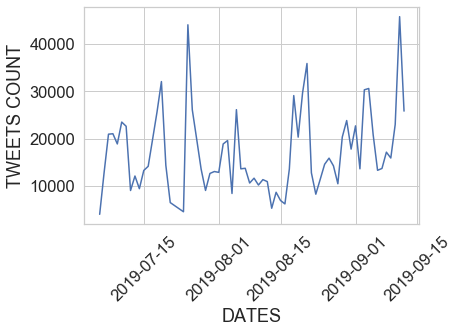

In [369]:
def graph_tweets_by_date():
    import matplotlib.pyplot as plt
    
    plt.figure()
    plt.plot(tweets_by_date['date'], tweets_by_date['count'])
    plt.xlabel('DATES')
    plt.ylabel('TWEETS COUNT')
    plt.xticks(rotation=45)
    

graph_tweets_by_date()